## Use customized KDE kernel to imitate LLaMA
- [x] Implement 2D fit 
- [x] Implement uncertainty of fit

In [192]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
# processed_series_path = Path(parent_dir) / '..' / 'llmICL' / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output
from ipywidgets import interact, IntSlider, FloatSlider

print(sys.path)
from ICL import MultiResolutionPDF
from models.baseline_models import *



def average_PDF_list(PDF_list, avg_interval = 6):
    """
    rolling average over a list of hierarchy PDFs
    """
    PDF_list_averaged = []
    common_bin_center_arr = PDF_list[0].bin_center_arr
    common_bin_width_arr = PDF_list[0].bin_width_arr
    for i in range(len(PDF_list)-avg_interval):
        avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
        avg_PDF = MultiResolutionPDF()
        avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
        PDF_list_averaged += [avg_PDF]
    return PDF_list_averaged
        
def gaussian_manifold_generator(PDF_list, sigma_list, mean_list):
    """
        PDF_list: example PDF
    """
    assert len(sigma_list) == len(mean_list), "Sigma list and mean list must be of the same length"
    PDF_manifold_list = copy.deepcopy(PDF_list[:len(sigma_list)])
    for i, (sigma, mean) in enumerate(zip(sigma_list, mean_list)):
        def cdf(x):
            return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
        PDF_manifold_list[i].discretize(cdf, mode = 'cdf')
        
    return PDF_manifold_list
    
def temperature_manifold_generator(true_PDF, temperature_list):
    PDF_manifold_list = [copy.deepcopy(true_PDF) for _ in temperature_list]
    for i, alpha in enumerate(temperature_list):
        # PDF_manifold_list[i].bin_height_arr += 0.01
        PDF_manifold_list[i].rescale_temperature(alpha)
    return PDF_manifold_list

def geodesic_from_true_stat(PDF_list, true_stat, geodesic_steps = 20):
    """
        PDF_list: example PDF
        true_stat: statistics of true distribution
    """

    PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
    PDF_ignorance = copy.deepcopy(PDF_list[0])
    def cdf(x):
        return np.clip(x / 10, 0, 1)
    PDF_ignorance.discretize(cdf, mode = "cdf")

    PDF_true = copy.deepcopy(PDF_list[-1])
    
    if true_stat['true_PDF'] is not None:
        PDF_true = true_stat['true_PDF']        
    else:
        if true_stat['dist type'] == 'gaussian':
            def cdf(x):
                return 0.5 * (1 + erf((x - true_stat['rescaled_true_mean']) / (true_stat['rescaled_true_sigma'] * np.sqrt(2))))
        elif true_stat['dist type'] == 'uniform':
            low = true_stat['rescaled_true_mean'] - true_stat['rescaled_true_sigma']
            high = true_stat['rescaled_true_mean'] + true_stat['rescaled_true_sigma']
            def cdf(x):
                return np.where((x >= low) & (x <= high), (x - low) / (high - low), np.where(x < low, 0, 1))
        PDF_true.discretize(cdf, mode = "cdf")


    PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
    PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
    dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
    denom = np.sin(dG)
    for i in range(geodesic_steps):
        a = i/geodesic_steps
        u_coef = np.sin((1-a)*dG)/denom
        v_coef = np.sin(a*dG)/denom
        PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)
    return PDF_geodesic_list        
    
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    series_dict = pickle.load(file.open('rb'))
    llama_size = series_dict['llama_size']
    random_seed = series_dict['random_seed']
    kernel = series_dict.get('kernel', '')
    # print(f"[{index}]: {file.name}, {llama_size}, {random_seed}, {kernel}")    

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [193]:
import re
def find_file(files, llama_size=None, sigma=None, kernel=None, random_seed=None, bw_function_name=None, dist_type=None, l=None):
    for file in files:
        matches = True
        
        # Extract sigma from filename
        sigma_match = re.search(r'sigma_([\d.]+)', file.name)
        l_match = re.search(r'l_([\d.]+)', file.name)
        file_sigma = float(sigma_match.group(1)) if sigma_match else None
        file_l = float(l_match.group(1)) if l_match else None
        
        series_dict = pickle.load(file.open('rb'))
        
        # Check llama_size
        if llama_size is not None and series_dict.get('llama_size') != llama_size:
            matches = False
        
        # Check sigma
        if sigma is not None and file_sigma != sigma:
            matches = False
        
        # Check kernel
        if kernel is not None and series_dict.get('kernel', '') != kernel:
            matches = False
        
        # Check random_seed
        if random_seed is not None and series_dict.get('random_seed') != random_seed:
            matches = False
            
        if l is not None and file_l != l:
            matches = False
            
        # check distribution type
        # Check distribution type
        if dist_type is not None:
            if dist_type not in file.name:
                matches = False
        
        # Check bw_function_name
        if bw_function_name is not None:
            if 'bw_function_name' not in series_dict or series_dict['bw_function_name'] != bw_function_name:
                matches = False
        if bw_function_name is None:
            if 'bw_function_name' in series_dict:
                matches = False
        
        if matches:
            return file
    return None

In [194]:
alpha = 1
avg_interval = 5
# avg_interval = 1
geodesic_steps = 40
# geodesic_steps = 5
gaussian_manifold = True
temperature_manifold = False
### Keep only 1 true statistic

use_true_PDF = 1

In [195]:
if gaussian_manifold and temperature_manifold:
    raise ValueError("Cannot plot both gaussian and temperature manifolds simultaneously")

PDF_list_multi_traj = []
true_statistics = []
traj_names = []

name = f"../figures/nD_kernel_fit_experiment"

default_dist = 'gaussian'


################ trajectory embedding
##########################################################################
##########################################################################
# # marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,100)
# marker_list = ["^","^", "^", "^", "^", "o","o","o","o","o","o","o",]
# color_list = ["C1", "C0", "C2", "C3", "C4", "C1", "C0", "C2", "C3", "C4"]
# name = f"../paper_figures/gaussian_0.1_7_13_70_KDE_hist_traj_embed"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian'),
#     find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None),
# ]
# target_idx_list = [0,1,2,3,4]

##########################################################################
##########################################################################

# marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,100)
# marker_list = ["^","^", "^", "^", "^", "o","o","o","o","o","o","o",]
# color_list = ["C1", "C0", "C2", "C3", "C4", "C1", "C0", "C2", "C3", "C4"]
# name = f"../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian', dist_type = 'uniform'),
#     find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None, dist_type = 'uniform'),
# ]
# target_idx_list = [0,1,2,3,4]

# ##########################################################################
# ##########################################################################

marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
PDF_slice = slice(0,100)
marker_list = ["^","^", "^", "^", "^", "o","o","o","o","o","o","o",]
color_list = ["C1", "C0", "C2", "C3", "C4", "C1", "C0", "C2", "C3", "C4"]
name = f"../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman"
selected_files = [
    
    find_file(all_files, llama_size='7b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='70b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='KDE', sigma=0.1001, kernel='gaussian', dist_type = 'uniform',bw_function_name='real_silverman'),
    find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None, dist_type = 'uniform'),
]
target_idx_list = [0,1,2,3,4]

# ##########################################################################
# ##########################################################################


# marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,100)
# marker_list = ["^","^", "^", "^", "^", "o","o","o","o","o","o","o",]
# color_list = ["C1", "C0", "C2", "C3", "C4", "C1", "C0", "C2", "C3", "C4"]
# name = f"../paper_figures/uniform_0.3_7_13_70_KDE_hist_traj_embed"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='70b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.3, kernel='gaussian', dist_type = 'uniform'),
#     find_file(all_files, llama_size='histogram', sigma=0.3, kernel=None, dist_type = 'uniform'),
# ]
# target_idx_list = [0,1,2,3,4]

# # marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,120)
# marker_list = ["^","^", "^","o","o","o","o","o","o","o",]
# color_list = [ "C0", "C3", "C4","C0", "C3", "C4"]
# name = f"../paper_figures/random_0.02_seed_8_0.1_13_KDE_hist_traj_embed"
# selected_files = [
    
#     # find_file(all_files, llama_size='7b', l=0.02, random_seed=8,  kernel=None),
#     find_file(all_files, llama_size='13b', l=0.02, random_seed=8,  kernel=None),
#     # find_file(all_files, llama_size='70b', l=0.02, random_seed=8, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.02, random_seed=8, kernel='gaussian'),
#     find_file(all_files, llama_size='histogram', l=0.02, random_seed=8, kernel=None,bw_function_name = None),
# ]
# target_idx_list = [0,1,2]

# ##########################################################################
# ##########################################################################

# # marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,120)
# marker_list = ["^","^", "^", "^","o","o","o","o","o","o","o",]
# color_list = [ "C1", "C0", "C3", "C4","C1","C0", "C3", "C4"]
# name = f"../paper_figures/random_0.02_seed_16_0.1_7_13_KDE_hist_traj_embed"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', l=0.02, random_seed=16,  kernel=None),
#     find_file(all_files, llama_size='13b', l=0.02, random_seed=16,  kernel=None),
#     # find_file(all_files, llama_size='70b', l=0.02, random_seed=16, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.02, random_seed=16, kernel='gaussian'),
#     find_file(all_files, llama_size='histogram', l=0.02, random_seed=16, kernel=None,bw_function_name = None),
# ]
# target_idx_list = [0,1,2,3]

##########################################################################
##########################################################################

# marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# PDF_slice = slice(0,120)
# marker_list = ["^","^", "^", "^","o","o","o","o","o","o","o",]
# color_list = [ "C1", "C0", "C3", "C4","C1","C0", "C3", "C4"]
# name = f"../paper_figures/random_0.5_seed_8_0.5_13_KDE_hist_traj_embed"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', l=0.5, random_seed=8,  kernel=None),
#     find_file(all_files, llama_size='13b', l=0.5, random_seed=8,  kernel=None),
#     # find_file(all_files, llama_size='70b', l=0.5, random_seed=8, kernel=None),
#     find_file(all_files, llama_size='KDE', l=0.5, random_seed=8, kernel='gaussian'),
#     find_file(all_files, llama_size='histogram', l=0.5, random_seed=8),
# ]
# target_idx_list = [0,1,2,3]


# Remove any None values in case a file wasn't found
selected_files = [f for f in selected_files if f is not None]
print(selected_files)



for file in selected_files:
    processed_dict = pickle.load(file.open('rb'))
    PDF_list_multi_traj.append(processed_dict['PDF_list'])
    llama_size = processed_dict['llama_size']
    kernel = processed_dict.get('kernel', None)
    bw_function_name = processed_dict.get('bw_function_name', None)
    print(llama_size, len(processed_dict['PDF_list']))
    if kernel is not None:
        traj_name = f"{llama_size}_{kernel}"
        # if bw_function_name is not None:
        #     traj_name += f"_{bw_function_name}"
        traj_names += [traj_name]
    else:
        traj_names += [f"{llama_size}"]
    true_stat = {
        'dist type':  processed_dict.get('dist type', default_dist),
        'rescaled_true_mean': processed_dict.get('rescaled_true_mean_arr', [None])[-1],
        'rescaled_true_sigma': processed_dict.get('rescaled_true_sigma_arr',[None])[-1],
        'true_PDF': processed_dict.get('true_PDF',None)
    }
    true_statistics.append(true_stat)


if use_true_PDF:
    true_PDF = true_statistics[0]['true_PDF']
    true_statistics = true_statistics[0:1]
else:
    # remove repeated true statistics
    true_statistics = [dict(t) for t in {tuple(d.items()) for d in true_statistics}]


### tune temperature and sort by bin center
for PDF_list in PDF_list_multi_traj:
    for PDF in PDF_list:
        PDF.sort_by_center()
        if alpha != 1:
            PDF.rescale_temperature(alpha)
            
### average over steps
for i in range(len(PDF_list_multi_traj)):
    PDF_list_multi_traj[i] = average_PDF_list(PDF_list_multi_traj[i], avg_interval = avg_interval)[PDF_slice]


[PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_uniform_centered_sigma_0.1_2.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_uniform_centered_sigma_0.1_0.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_uniform_centered_sigma_0.1_4.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_uniform_centered_sigma_0.1001_99.pkl'), PosixPath('/home/admin-quad/Toni/LLMICL_inPCA/processed_series/uncorrelated_uniform_centered_sigma_0.1_6.pkl')]
7b 400
13b 400
70b 400
KDE 400
histogram 400


In [196]:
file = find_file(all_files, llama_size='histogram', l=0.5)

In [197]:
with open(file, 'rb') as f:
    loaded_data = pickle.load(f)
loaded_data['random_seed']

0

In [198]:
name_convert_dict = {'7b':'LLaMA-2 7b', '70b_NA':'LLaMA-2 70b', '13b_NA':'LLaMA-2 13b', '13b':'LLaMA-2 13b', '70b':'LLaMA-2 70b', 'KDE_gaussian': 'gaussian KDE', 'histogram_NA': "histogram", 'KDE_exponential': 'exponential KDE', 'KDE_tophat': 'tophat KDE'}
traj_names = [name_convert_dict.get(name, name) for name in traj_names]
print(traj_names)


['LLaMA-2 7b', 'LLaMA-2 13b', 'LLaMA-2 70b', 'gaussian KDE', 'histogram']


In [199]:
### check that the rescaled full series is the one used by LLaMA

processed_dict = pickle.load(selected_files[3].open('rb'))
rescaled_full_series = processed_dict['rescaled_full_series']
rescaled_full_series[:5]

array([4.95423636, 4.66103726, 5.03550867, 4.95375551, 4.94306298])

### Visualize multi-digit trajectory


In [200]:
len(PDF_list_multi_traj[0])
# PDF_list_multi_traj[0]

100

In [201]:
import matplotlib.pyplot as plt

@interact(step=IntSlider(min=0, max=len(PDF_list_multi_traj[0])-1, step=1, value=10))
def plot_PDFs(step):
    fig, axes = plt.subplots(len(PDF_list_multi_traj), 1, figsize=(6, 3))
    if len(PDF_list_multi_traj) == 1:
        axes = [axes]
    
    for i, (name, PDF_traj) in enumerate(zip(traj_names, PDF_list_multi_traj)):
        axes[i].clear()
        PDF_traj[step].plot(ax=axes[i], statistic = False)
        axes[i].set_title(f"{name}")
    
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='step', max=99), Output()), _dom_classes=('widget-intera…

### Fit KDE

In [202]:
import math
# def poly_exp_dist(n):
#     normalization = 2 * math.gamma(1+1/n)
#     def curry_func(x):
#         return np.exp(-np.power(np.abs(x), n)) / normalization 
#     return curry_func

def poly_exp_dist(n):
    """
    Constant variance
    """
    normalization = 2 * math.gamma(1+1/n)
    var = math.gamma(3/n + 1) / math.gamma(1+1/n) / 3
    std = np.sqrt(var)
    def curry_func(x):
        return np.exp(-np.power(np.abs(x * std), n)) * std / normalization 
    return curry_func

@interact(n=FloatSlider(min=0.3, max=20, step=0.01, value=0.3, description='n:'))
def plot_poly_exp_dist(n):
    kernel = poly_exp_dist(n)
    x_values = np.linspace(-5, 5, 400)
    p_values = kernel(x_values)
    # Calculate the variance of the distribution
    variance = np.sum(x_values**2 * p_values)
    # Calculate the total probability (area under the curve)
    total_probability = np.trapz(p_values, x_values)
    print(f"Total probability: {total_probability:.4f}")
    print(f"Variance of the distribution: {variance:.4f}")
    plt.figure(figsize=(10, 4))
    plt.plot(x_values, p_values)
    plt.title(f'Normalized Poly-exponential Distribution (n = {n:.2f})')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    # plt.ylim(0, 2)
    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='n:', max=20.0, min=0.3, step=0.01), Output()), _dom_…

In [203]:
### Set target
Target_PDF_list_list = [PDF_list_multi_traj[target_idx][PDF_slice] for target_idx in target_idx_list]


In [204]:
from scipy.optimize import minimize

# Initial guess for parameters (bw, n)
initial_guess = [0.1, 2]

# Bounds for parameters: bw in [1e-3, 1e2], n in [0.1, 1.0]
# bounds = [(1e-3, 1e2), (0.1, 5.0)]
bounds = [(1e-3, 1e2), (0.1, 10.0)]
# bounds = [(1e-4, 1e2), (0.2, 0.2)]
# bounds = [(1e-3, 1e2), (0.4, 0.4)]
# bounds = [(1e-3, 1e2), (1, 1)]
# bounds = [(1e-3, 1e2), (2, 2)]


def objective_function(params, data, LLaMA_PDF):
    bw, n = params
    kernel = poly_exp_dist(n)
    KDE_PDF = KDE(data, kernel=kernel, bw=bw)
    return LLaMA_PDF.Hel_dist(KDE_PDF)
    # return LLaMA_PDF.L2_dist(KDE_PDF)

optimal_params_list = []
parameter_variances_list = []
minimized_hel_distances_list = []
optimal_KDE_PDFs_list = []

for target_PDF_list in Target_PDF_list_list:

    optimal_params = []
    parameter_variances = []
    minimized_hel_distances = []
    optimal_KDE_PDFs = []

    # Iterate over all steps
    for step in range(len(target_PDF_list )):
        target_PDF = target_PDF_list[step]
        data = rescaled_full_series[:step+1]  # +1 to include the current step

        # Optimize
        result = minimize(
            objective_function,
            initial_guess,
            args=(data, target_PDF),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 50000}
        )
        
        # initial_guess = result.x  # Use last result as new initial guess
        optimal_bw, optimal_n = result.x
        minimized_objective = result.fun
        optimal_params.append((optimal_bw, optimal_n))
        minimized_hel_distances.append(minimized_objective)
        
        # Extract diagonal elements of the Hessian inverse
        hessian_inv = result.hess_inv.todense() 
        hessian_inv_diag = np.diag(hessian_inv)
        parameter_variances.append(hessian_inv_diag)

        # Generate and save the optimal KDE_PDF
        optimal_kernel = poly_exp_dist(optimal_n)
        optimal_KDE_PDF = KDE(data, kernel=optimal_kernel, bw=optimal_bw)
        optimal_KDE_PDFs.append(optimal_KDE_PDF)

    optimal_params_list.append(optimal_params)
    parameter_variances_list.append(parameter_variances)
    minimized_hel_distances_list.append(minimized_hel_distances)
    optimal_KDE_PDFs_list.append(optimal_KDE_PDFs)





In [205]:
for optimal_KDE_PDFs, target_idx in zip(optimal_KDE_PDFs_list, target_idx_list):
    traj_names.append(f"KDE fitted to {traj_names[target_idx]}")
    PDF_list_multi_traj.append(optimal_KDE_PDFs)
    

/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_245727/3049947449.py:78: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0,100)


../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_fitted_to_LLaMA-2 7b_hel_dist_False.png


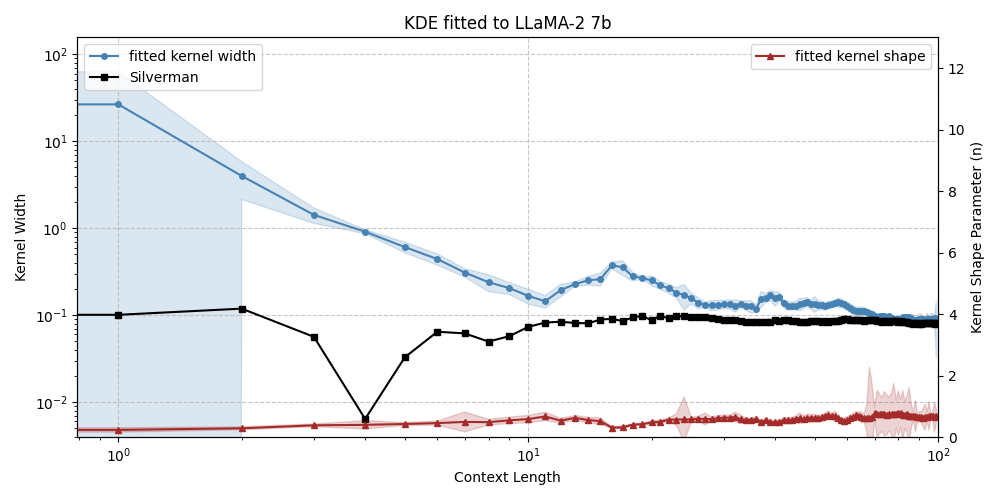

../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_fitted_to_LLaMA-2 13b_hel_dist_False.png


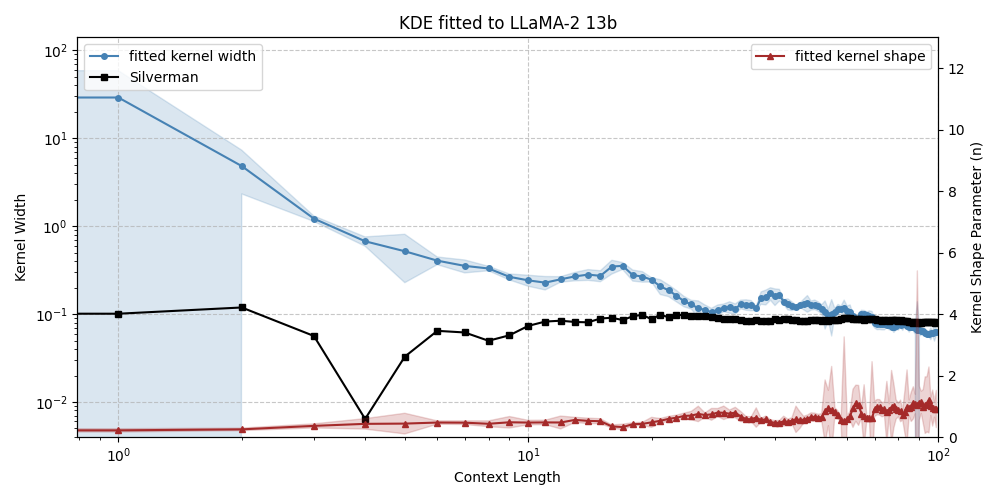

../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_fitted_to_LLaMA-2 70b_hel_dist_False.png


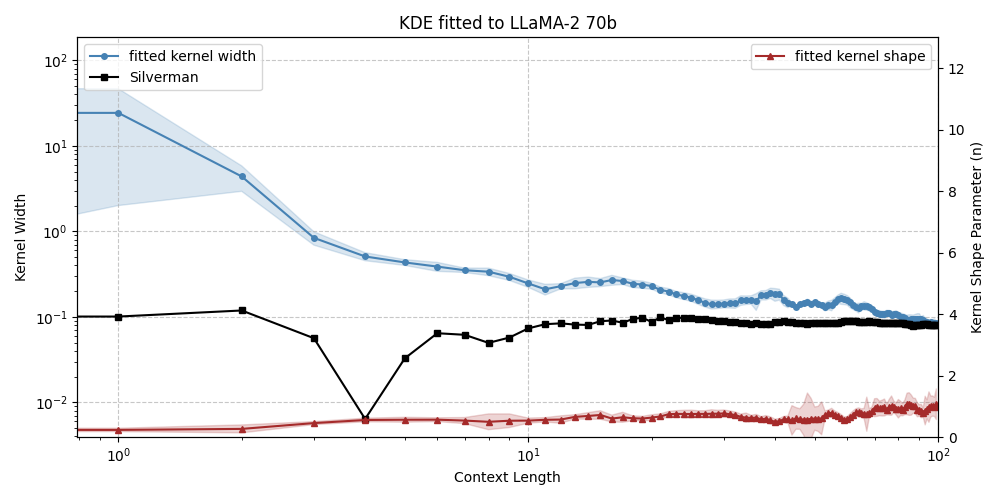

../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_fitted_to_gaussian KDE_hel_dist_False.png


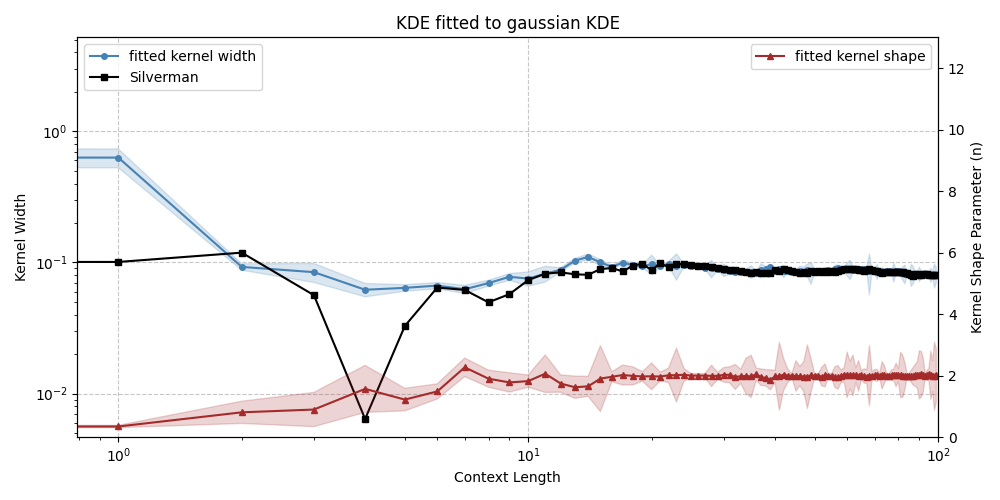

../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_fitted_to_histogram_hel_dist_False.png


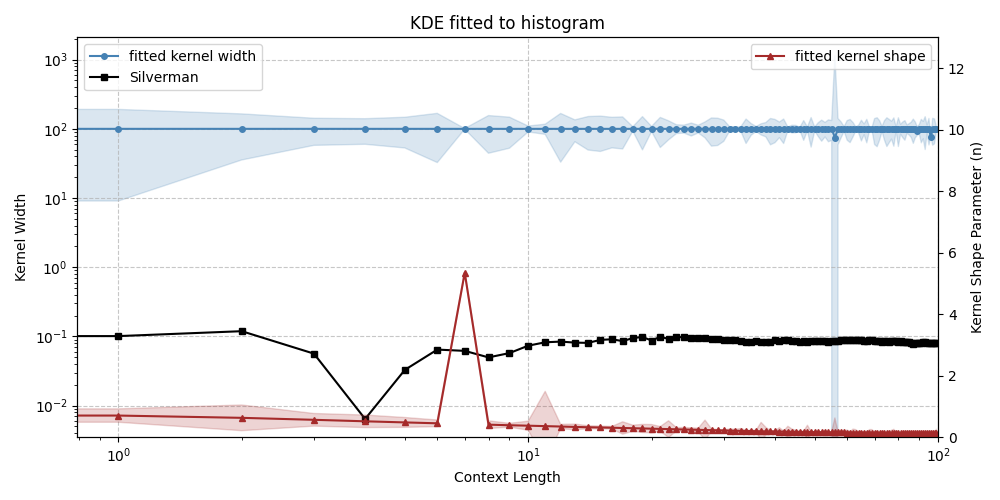

In [206]:
plot_hel_dist = True
plot_hel_dist = False

# Calculate Silverman's rule bandwidths
# def silverman_bandwidth(data):
#     n = len(data)
#     std = np.std(data, ddof=1)  # Use sample standard deviation
#     iqr = np.percentile(data, 75) - np.percentile(data, 25)
#     return 1.06 * min(std, iqr/1.34) * n**(-1/5)
#     # return 1.06 * n**(-1/5) 
    
def silverman_bandwidth(data):
    n = len(data)
    std = np.std(data, ddof=1)  # Use sample standard deviation
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bw = 1.06 * min(std, iqr/1.34) * n**(-1/5)
    if not np.isnan(bw):
        return bw
    else:
        return 1.06 * n**(-1/5)


for plot_idx in target_idx_list:
    optimal_params = optimal_params_list[plot_idx]
    parameter_variances = parameter_variances_list[plot_idx]
    minimized_hel_distances = minimized_hel_distances_list[plot_idx]
    optimal_KDE_PDFs = optimal_KDE_PDFs_list[plot_idx]
    # Unpack optimal parameters
    optimal_bandwidths, optimal_ns = zip(*optimal_params)

    # Unpack parameter variances
    bandwidth_variances, n_variances = zip(*parameter_variances)

    # Convert to numpy arrays for easier manipulation
    bandwidth_variances = np.array(bandwidth_variances)
    n_variances = np.array(n_variances)

    # Calculate standard errors
    bandwidth_std_errors = np.sqrt(bandwidth_variances) / 15
    n_std_errors = np.sqrt(n_variances) / 15

    # silverman_bandwidths = [silverman_bandwidth(rescaled_full_series[:i+1]) for i in range(1, len(optimal_bandwidths)+1)]
    silverman_bandwidths = [silverman_bandwidth(rescaled_full_series[:i]) for i in range(1, len(optimal_bandwidths)+1)]

    if plot_hel_dist:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

    # Plot bandwidths
    ax1.plot(optimal_bandwidths, marker='o', linestyle='-', markersize=4, label='fitted kernel width', c='steelblue')
    ax1.fill_between(range(len(optimal_bandwidths)), 
                    np.array(optimal_bandwidths) - bandwidth_std_errors, 
                    np.array(optimal_bandwidths) + bandwidth_std_errors, 
                    alpha=0.2, color='steelblue')

    ax1.plot(silverman_bandwidths, marker='s', linestyle='-', markersize=4, label='Silverman', c='black')

    ax1.set_ylabel('Kernel Width')
    ax1.set_xlabel('Context Length')
    ax1.set_xscale('log') 
    ax1.set_yscale('log') 
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Create a second y-axis for optimal n
    ax2 = ax1.twinx()
    ax2.plot(optimal_ns, marker='^', linestyle='-', markersize=4, color='brown', label='fitted kernel shape')
    ax2.fill_between(range(len(optimal_ns)), 
                    np.array(optimal_ns) - n_std_errors, 
                    np.array(optimal_ns) + n_std_errors, 
                    alpha=0.2, color='brown')

    ax2.set_ylabel('Kernel Shape Parameter (n)')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, 13)

    ax1.set_xlim(0,100)
    plt.title(f"KDE fitted to {traj_names[plot_idx]}")

    # plt.title('fitted bandwidth and kernel shape schedule')
    # Save the figure
    save_path = f"{name}_fitted_to_{traj_names[plot_idx]}_hel_dist_{plot_hel_dist}.png"
    print(save_path)
    plt.savefig(save_path, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

In [207]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np
length = PDF_slice.stop - PDF_slice.start
@interact(step=IntSlider(min=0, max=length-1, step=1, value=10),
          use_log_scale=Checkbox(value=False, description='Use Log Scale'))
def plot_PDFs_and_kernel(step, use_log_scale):
    plt.clf()  # Clear the entire figure
    fig, axes = plt.subplots(len(PDF_list_multi_traj)+1, 1, figsize=(10, 16))
    if len(PDF_list_multi_traj) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()  # Ensure axes is always a 1D array
    
    for i, (name, PDF_traj) in enumerate(zip(traj_names, PDF_list_multi_traj)):
        axes[i].clear()  # Clear the individual subplot
        PDF_traj[step].plot(ax=axes[i], statistic=False)
        axes[i].set_title(name)
        if use_log_scale:
            axes[i].set_yscale('log')
            axes[i].set_ylim(1e-3, 1e2)
        else:
            axes[i].set_yscale('linear')
    
    # Plot the optimal kernel
    axes[-1].clear()
    optimal_bw, optimal_n = optimal_params[step]
    kernel = poly_exp_dist(optimal_n)
    x = np.linspace(-5, 5, 1000)
    y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
    axes[-1].plot(x, y)
    axes[-1].set_title(f'Optimal Kernel (bw={optimal_bw:.4f}, n={optimal_n:.4f})')
    axes[-1].set_xlabel('x')
    axes[-1].set_ylim(0.001,10)
    axes[-1].set_ylabel('Density')
    if use_log_scale:
        axes[-1].set_yscale('log')
        
    else:
        axes[-1].set_yscale('linear')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='step', max=99), Checkbox(value=False, description='Use …

In [208]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np

def plot_PDFs_and_kernel(steps_list=None, use_log_scale=True):
    length = PDF_slice.stop - PDF_slice.start

    def plot_step(step):
        plt.clf()  # Clear the entire figure
        fig = plt.figure(figsize=(15, 1.5))
        
        # Create a gridspec with 1 row and 4 columns
        gs = fig.add_gridspec(1, 4, width_ratios=[2, 2, 2, 1.5], wspace=0.1)
        
        axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
        
        for i, (traj_name, PDF_traj) in enumerate(zip(traj_names[:3], PDF_list_multi_traj[:3])):
            PDF_traj[step].plot(ax=axes[i], statistic=False)
            axes[i].set_title(traj_name)
            if use_log_scale:
                axes[i].set_yscale('log')
                axes[i].set_ylim(1e-3, 1e2)
            else:
                axes[i].set_yscale('linear')
            
            # Remove y-axis labels for all but the first plot
            if i > 0:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
                # Remove y-axis ticks for all but the first plot
                axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
                
            # Adjust position to remove space between first three subplots
            if i > 0 and i < 3:
                pos = axes[i].get_position()
                axes[i].set_position([pos.x0 - 0.02 * i, pos.y0, pos.width, pos.height])
        
        # Plot the optimal kernel
        optimal_bw, optimal_n = optimal_params[step]
        silverman_bw = silverman_bandwidths[step]
        kernel = poly_exp_dist(optimal_n)
        gaussian_kernel = poly_exp_dist(2)
        x = np.linspace(-5, 5, 1000)
        y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
        gaussian_y = gaussian_kernel(x / silverman_bw) / silverman_bw
        # axes[-1].set_title(f'kernels')
        axes[-1].plot(x, y, label='fitted kernel')
        axes[-1].plot(x, gaussian_y, color='red', label='gaussian kernel')
        axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
        axes[-1].set_xlabel('x')
        if use_log_scale:
            axes[-1].set_ylim(0.001, 10)
        
        axes[0].set_ylabel('Density')
        
        if use_log_scale:
            axes[-1].set_yscale('log')
        else:
            axes[-1].set_yscale('linear')

        # Set the step number as the title of the entire figure
        fig.suptitle(f'context length {step}', fontsize=16, y=1.25)

        if steps_list is not None:
            # Save the figure
            save_path = f"{name}_fitted_kernel_visualization_{step}_Log_{use_log_scale}.png"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    if steps_list is None:
        # Interactive mode
        interact(plot_step, 
                 step=IntSlider(min=0, max=length-1, step=1, value=10),
                 use_log_scale=Checkbox(value=True, description='Use Log Scale'))
    else:
        # Non-interactive mode: iterate over steps_list and save images
        for step in steps_list:
            plot_step(step)



### Figure 1 elements

In [209]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np

def plot_PDFs_and_kernel(steps_list=None, use_log_scale=True):
    length = PDF_slice.stop - PDF_slice.start

    def plot_step(step):
        plt.clf()  # Clear the entire figure
        fig = plt.figure(figsize=(15, 1.5))
        
        # Create a gridspec with 1 row and 4 columns
        gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 2], wspace=0.1)
        
        axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
        
        for i, (traj_name, PDF_traj) in enumerate(zip(traj_names[:3], PDF_list_multi_traj[:3])):
            PDF_traj[step].plot(ax=axes[i], statistic=False, uniform_color = color_list[i])
            axes[i].set_title(traj_name)
            if use_log_scale:
                axes[i].set_yscale('log')
                axes[i].set_ylim(0.2e-3, 1e2)
            else:
                axes[i].set_yscale('linear')
            
            # Remove y-axis labels for all but the first plot
            if i > 0:
                axes[i].set_ylabel('')
                axes[i].set_yticklabels([])
                # Remove y-axis ticks for all but the first plot
                axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
                
            # Adjust position to remove space between first three subplots
            if i > 0 and i < 3:
                pos = axes[i].get_position()
                axes[i].set_position([pos.x0 - 0.025 * i, pos.y0, pos.width, pos.height])
        
        # Plot the optimal kernel
        optimal_bw, optimal_n = optimal_params[step]
        silverman_bw = silverman_bandwidths[step]
        kernel = poly_exp_dist(optimal_n)
        gaussian_kernel = poly_exp_dist(2)
        x = np.linspace(-5, 5, 1000)
        y = kernel(x / optimal_bw) / optimal_bw  # Scale the kernel by bandwidth
        gaussian_y = gaussian_kernel(x / silverman_bw) / silverman_bw
        
        axes[0].set_ylabel('Density')
        

        # Set the step number as the title of the entire figure
        fig.suptitle(f'context length {step}', fontsize=16, y=1.25)

        if steps_list is not None:
            # Save the figure
            save_path = f"{name}_fitted_kernel_visualization_{step}_Log_{use_log_scale}.png"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close(fig)
        else:
            plt.show()

    if steps_list is None:
        # Interactive mode
        interact(plot_step, 
                 step=IntSlider(min=0, max=length-1, step=1, value=10),
                 use_log_scale=Checkbox(value=True, description='Use Log Scale'))
    else:
        # Non-interactive mode: iterate over steps_list and save images
        for step in steps_list:
            plot_step(step)



In [210]:
# Usage:
# For interactive mode:
plot_PDFs_and_kernel()

interactive(children=(IntSlider(value=10, description='step', max=99), Output()), _dom_classes=('widget-intera…

In [211]:

# For non-interactive mode:
# plot_PDFs_and_kernel(steps_list=[100], use_log_scale=True)
# plot_PDFs_and_kernel(steps_list=[0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,130,140], use_log_scale=True)
# plot_PDFs_and_kernel(steps_list=[0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,130,140], use_log_scale=False)


In [212]:
### Calculate geodesic 
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]
for true_stat in true_statistics:
    PDF_geodesic_list_multi_traj += [geodesic_from_true_stat(example_PDF_list,
                                                             true_stat,
                                                             geodesic_steps=geodesic_steps)]

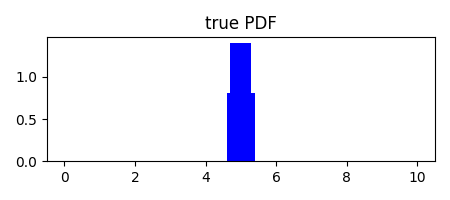

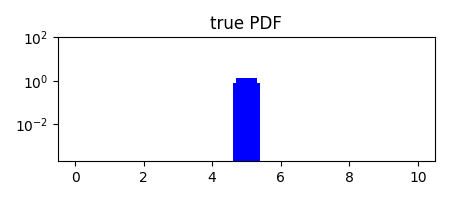

In [213]:
true_PDF = PDF_geodesic_list_multi_traj[-1][-1]

# Create a figure with two subplots
for use_log in [False,True]:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))
    true_PDF.plot(ax=ax, statistic=False,uniform_color='blue')
    if use_log:
        ax.set_yscale('log')
        ax.set_ylim(0.2e-3, 1e2)
    

    save_path = f"{name}_true_PDF_Log_{use_log}.png"
    ax.set_title("true PDF") 
    plt.savefig(save_path, bbox_inches='tight')
    plt.tight_layout()


### Visualization


In [214]:
### Calculate gaussian sub-manifold:
if gaussian_manifold:
    # same length as geodesic, for easy plotting
    sigma_list = np.linspace(0,5,geodesic_steps)
    mean_list = np.array([5]*geodesic_steps)
    PDF_list = PDF_list_multi_traj[0]
    sub_manifold_list = gaussian_manifold_generator(PDF_list, sigma_list, mean_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    

/tmp/ipykernel_245727/3062036002.py:50: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
/tmp/ipykernel_245727/3062036002.py:50: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))


In [215]:
### Calculate temperature sub-manifold:
if temperature_manifold:
    temperature_list = np.logspace(np.log10(1), np.log10(20), geodesic_steps)
    sub_manifold_list = temperature_manifold_generator(true_PDF, temperature_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    %matplotlib inline 
    from ipywidgets import interact
    def plotter(idx):
        fig=plt.figure(figsize = (5,1))
        ax = fig.add_subplot(111)
        sub_manifold_list[idx].plot(ax=ax, statistic = False)

    interact(plotter, idx=(0, geodesic_steps-1, 1))

In [216]:

traj_len = PDF_slice.stop - PDF_slice.start
PDF_emb_list = []
for PDF_list in PDF_list_multi_traj:
    PDF_emb_list += PDF_list[PDF_slice]

for i, geodesic_list in enumerate(PDF_geodesic_list_multi_traj):
    if i == 0:
        PDF_emb_list += geodesic_list
    else:
        PDF_emb_list += geodesic_list[1:]
        

### Compute pair-wise distance

In [217]:
# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)
D_Hel = np.zeros((num_PDFs, num_PDFs))


In [218]:
### un-parallelized

# # Populate the upper triangle of the matrix with the BT distances.
# for i in range(num_PDFs):
#     for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
#         D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [219]:
### parallelized

import numpy as np
from multiprocessing import Pool, cpu_count

def compute_distance(args):
    i, j, PDF_i, PDF_j = args
    return (i, j, PDF_j.Hel_dist(PDF_i))

def parallel_distance_matrix(PDF_emb_list):
    num_PDFs = len(PDF_emb_list)
    D_Hel = np.zeros((num_PDFs, num_PDFs))
    
    # Prepare arguments for parallel processing
    args = [(i, j, PDF_emb_list[i], PDF_emb_list[j]) 
            for i in range(num_PDFs) 
            for j in range(i+1, num_PDFs)]
    
    # Use all available CPU cores
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_distance, args)
    
    # Fill the matrix with the results
    for i, j, distance in results:
        D_Hel[i, j] = distance
    
    return D_Hel

# Use the function
D_Hel = parallel_distance_matrix(PDF_emb_list)

In [220]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([272.30062914,  17.790683  ,  15.53700828])

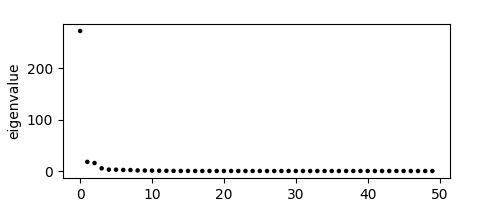

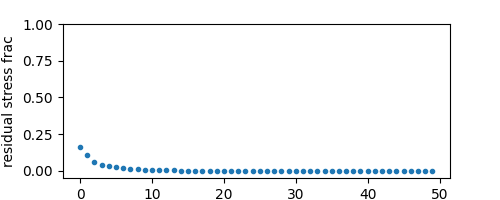

In [221]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
U_rescaled_original = U_rescaled.copy() 
# U_rescaled = U * sigma

# %matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
# plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=100)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('residual stress frac')
plt.ylim(-0.05,1)
sigma[:3]

### 3D Embedding

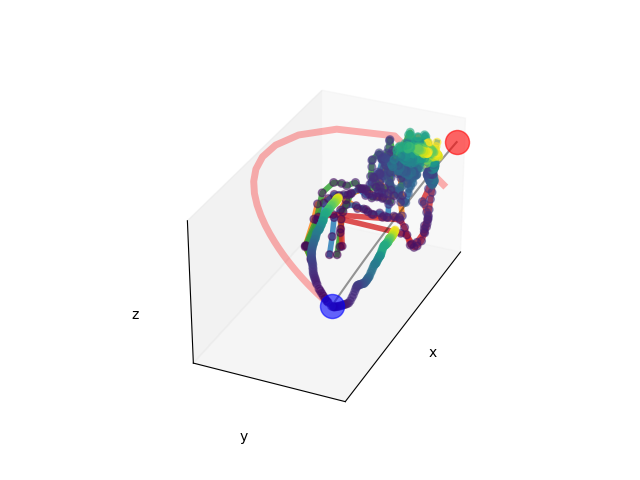

In [222]:
interactive = 1

time_cutoff = -geodesic_steps
interval = 1
geodesic = True
shadows = False
shadow_alpha = 0.05

num_geodesics = len(PDF_geodesic_list_multi_traj)
num_trajs = len(PDF_list_multi_traj)
submanifold = gaussian_manifold or temperature_manifold

filenames = []

def plotter_with_initial_angle(angle, save_path = None):

    if interactive:
        #interactive 3D plot
        %matplotlib widget 
        fig = plt.figure(dpi = 100)
    else:    
    # static 3D plot
        %matplotlib inline 
        fig = plt.figure(dpi = 100, figsize=(8,8))
        
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_trajs):
        # learning trajectories
        ax.scatter3D(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], c=range(int(traj_len/interval)), s = 30, alpha = 0.5)
        ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], alpha = 0.8, lw = 4, c = color_list[i])

    # ignorance is the shared
    ign_index = num_trajs * traj_len
    ax.scatter3D(U_rescaled[ign_index,0], U_rescaled[ign_index,1], U_rescaled[ign_index,2], c='blue', s = 300, alpha = 0.6)

    for i in range(num_geodesics-submanifold):
        # geodesics
        start = ign_index+i*(geodesic_steps-1)+1
        end = ign_index+(i+1)*(geodesic_steps-1)+1
        # print(end, start)
        ax.scatter3D(U_rescaled[end-1,0], U_rescaled[end-1,1], U_rescaled[end-1,2], c='red', s = 300, alpha = 0.6)
        if geodesic:
            ax.plot(U_rescaled[start : end,0], 
                    U_rescaled[start : end,1],
                    U_rescaled[start : end,2], c='black', alpha = 0.4)

    if gaussian_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")

    if temperature_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "temperature manifold")


    # if not interactive:
    #     ax.legend()
            
            
    x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
    y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
    z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    if shadows:
        for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):        
            for i in range(len(PDF_list_multi_traj)):
                ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[0]], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = shadow_alpha, zs=zs, zdir=zdir)

        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=30, azim=angle)
    # plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
    # plt.axis('equal')
    ax.set_aspect('equal')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        filenames.append(save_path)
        plt.close(fig)  # Save the plot without displaying it
    
    
plotter_with_initial_angle(angle = 24)    

### Animate

In [223]:
# filenames = []
# num_frames = 300
# for frame_idx in range(num_frames):

#     angle = 2 * 360 * (frame_idx/num_frames)
#     save_path = f"../figures/animation/{frame_idx}.png"
#     plotter_with_initial_angle(angle = angle, save_path = save_path)    

In [224]:
# # Create a GIF using snapshot made
# import imageio.v2 as imageio
# remark = name.split("/")[-1]
# with imageio.get_writer(f'../figures/{remark}.gif', mode='I', duration=30000 / num_frames, loop=0) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

### 2D Embedding


In [225]:
invert_x = 0
invert_y = 0

fraction of explained variance 89%


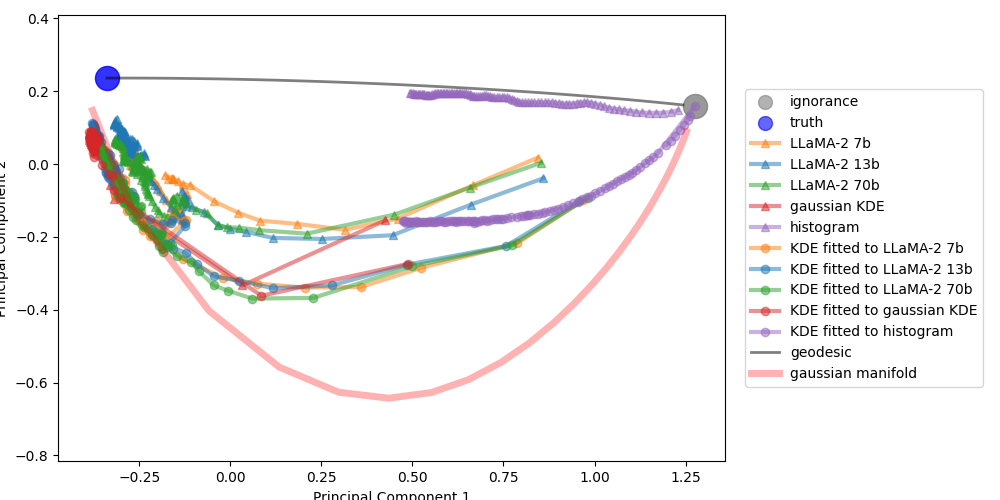

In [226]:
dim1 = 0
dim2 = 1
U_rescaled = U_rescaled_original.copy() 
if invert_x:
    U_rescaled[:,dim1] = -U_rescaled[:,dim1]
if invert_y:
    U_rescaled[:,dim2] = -U_rescaled[:,dim2]


fig = plt.figure(dpi = 100, figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter([],[], c='gray', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'truth')
for i in range(len(PDF_list_multi_traj)):    
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c=range(int(traj_len/interval)), alpha = 0.5)
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c = color_list[i], alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], alpha = 0.5, lw=3, 
            label = traj_names[i], 
            c = color_list[i],
            marker = marker_list[i])

# ignorance is shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='grey', s = 300, alpha = 0.8)
# ax.annotate('ignorance', (U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2]),textcoords="offset points", xytext=(10,10), ha='center')

for i in range(num_geodesics-submanifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='blue', s = 300, alpha = 0.8)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha=0.5, lw=2)


if geodesic:
    ax.plot([], c='black', alpha=0.5, lw=2, label = 'geodesic')  # Increased line width to thicken the line
# ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if submanifold:
    label = "temperature manifold" if temperature_manifold else "gaussian manifold"
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = label)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks

# Invert the y-axis
# ax.invert_yaxis()


# remove repeated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc='best')


# Move the legend outside the plot
# plt.legend(by_label.values(), by_label.keys(), loc='upper right')
# Move the legend outside the plot to the right
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

# Adjust the layout to prevent the legend from being cut off
plt.tight_layout()
# Label x and y axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

print(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal')
save_path = f"{name}_Hellinger_2D_{explained_var[1]/total_var*100:.0f}.png"
plt.savefig(save_path, bbox_inches='tight')  # Ensure the legend is included in the saved figure



In [227]:
save_path = f"{name}_Hellinger_2D_{explained_var[1]/total_var*100:.0f}.png"
save_path

'../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_Hellinger_2D_89.png'

### Whole trajectory embedding


In [228]:
traj_D = np.zeros((len(PDF_list_multi_traj), len(PDF_list_multi_traj)))
for i in range(len(PDF_list_multi_traj)):
    for j in range(i+1, len(PDF_list_multi_traj)):
        traj_i_slice = slice(i*traj_len,(i+1)*traj_len)
        traj_j_slice = slice(j*traj_len,(j+1)*traj_len)
        traj_dist_ij = np.sum(np.diag(D_Hel[traj_i_slice, traj_j_slice]))
        traj_D[i,j] =  traj_dist_ij

traj_D = traj_D + traj_D.T

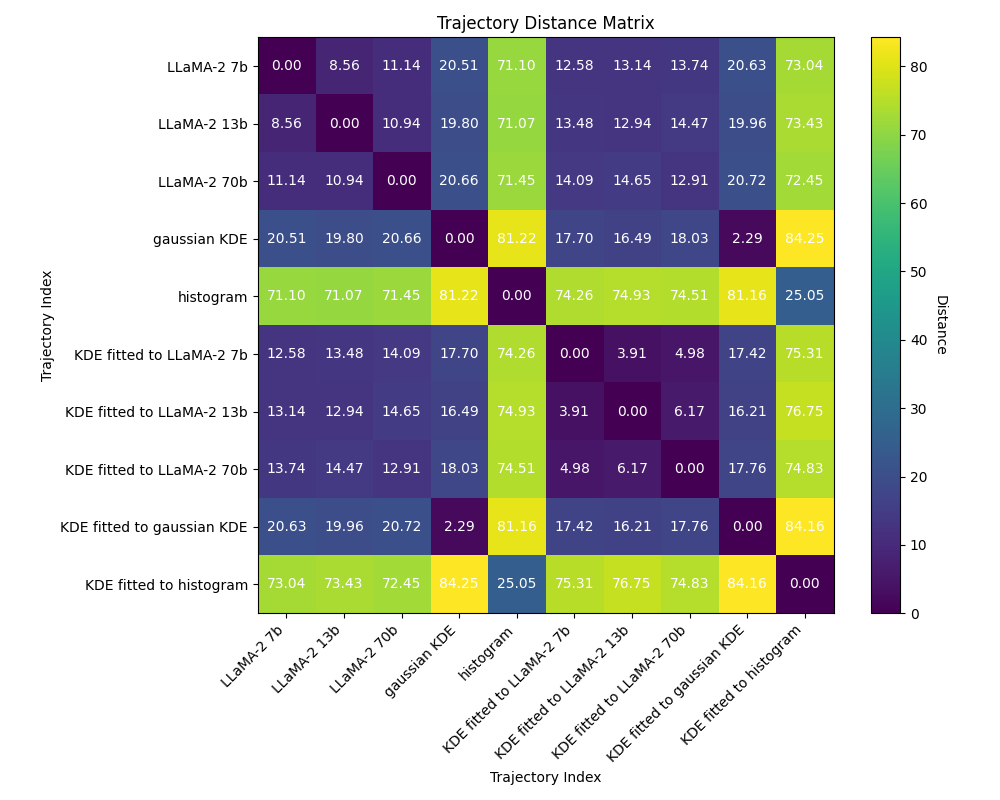

In [229]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(traj_D, cmap='viridis')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Distance', rotation=-90, va="bottom")

# Add text annotations
for i in range(traj_D.shape[0]):
    for j in range(traj_D.shape[1]):
        text = ax.text(j, i, f'{traj_D[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title("Trajectory Distance Matrix")
ax.set_xlabel("Trajectory Index")
ax.set_ylabel("Trajectory Index")

# Set tick labels
ax.set_xticks(np.arange(len(traj_names)))
ax.set_yticks(np.arange(len(traj_names)))
ax.set_xticklabels(traj_names, rotation=45, ha='right')
ax.set_yticklabels(traj_names)


plt.tight_layout()
plt.show()

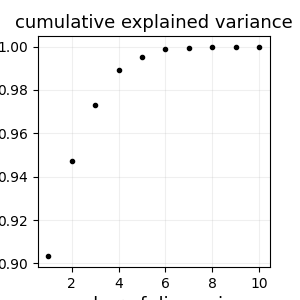

In [230]:
P = np.eye(len(PDF_list_multi_traj)) - np.ones(len(PDF_list_multi_traj))/len(PDF_list_multi_traj)
XXT_Hel_traj = -P @ np.square(traj_D) @ P
sigma_traj, U_traj = np.linalg.eigh(XXT_Hel_traj)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx_traj = np.argsort(np.abs(sigma_traj))[::-1]
sigma_traj = sigma_traj[idx_traj]
U_traj = U_traj[:, idx_traj]
U_rescaled_traj = U_traj * np.sqrt(np.abs(sigma_traj))

dim1 = 0
dim2 = 1

total_var = np.sum(np.abs(sigma_traj))
explained_var = np.cumsum(np.abs(sigma_traj))
plt.figure(figsize=(3,3), dpi=100)
plt.plot(range(1, len(explained_var)+1), explained_var/total_var, marker='.', lw=0, color='black')
plt.xlabel('number of dimensions', fontsize=13)
plt.ylabel('explained fraction', fontsize=13)
plt.title('cumulative explained variance', fontsize=13)
plt.grid(True, which="both", ls="-", alpha=0.2)


Figure saved as ../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_trajectory_embedding_dim1_2.png


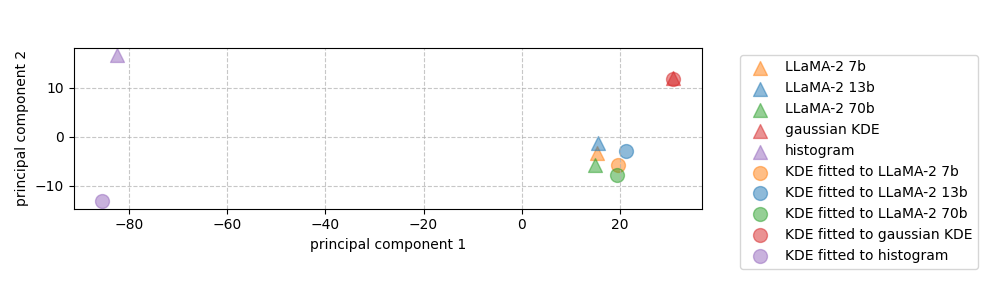

fraction of explained Hellinger variance 94%


In [231]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))

# Plot the points
for i, (Name, color, marker) in enumerate(zip(traj_names, color_list, marker_list)):
    ax.scatter(U_rescaled_traj[i, dim1], U_rescaled_traj[i, dim2], 
               s=100, c=color, marker=marker, label=Name, alpha = 0.5)
    

# Set title and labels
# plt.title(f"Trajectory Embedding")
plt.xlabel(f"principal component 1")
plt.ylabel(f"principal component 2")

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()

# Save the figure
save_path = f"{name}_trajectory_embedding_dim{dim1+1}_{dim2+1}.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Figure saved as {save_path}")
# Set aspect ratio to 'equal' to make axis ratio equal
ax.set_aspect('equal')

# Show the plot
plt.show()

print(f"fraction of explained Hellinger variance {int((explained_var/total_var)[1]*100)}%")

Figure saved as ../paper_figures/uniform_0.1_7_13_70_KDE_hist_traj_embed_real_silverman_trajectory_embedding_dim1_2_small.png


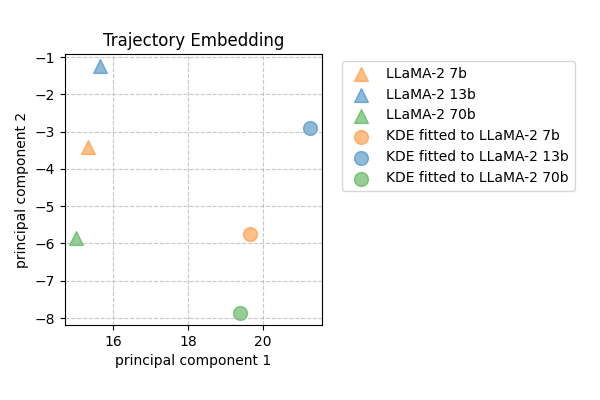

fraction of explained Hellinger variance 94%


In [232]:
import matplotlib.pyplot as plt

plot_indices = [0,1,2,5,6,7]  # This will plot the first three trajectories

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the points
for i in plot_indices:
    Name = traj_names[i]
    color = color_list[i]
    marker = marker_list[i]
    ax.scatter(U_rescaled_traj[i, dim1], U_rescaled_traj[i, dim2], 
               s=100, c=color, marker=marker, label=Name, alpha=0.5)


# Set title and labels
plt.title(f"Trajectory Embedding")
plt.xlabel(f"principal component 1")
plt.ylabel(f"principal component 2")

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()

# Save the figure
save_path = f"{name}_trajectory_embedding_dim{dim1+1}_{dim2+1}_small.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
print(f"Figure saved as {save_path}")
# Set aspect ratio to 'equal' to make axis ratio equal
ax.set_aspect('equal')

# Show the plot
plt.show()

print(f"fraction of explained Hellinger variance {int((explained_var/total_var)[1]*100)}%")

### 1D Embedding: Hellinger distance to truth


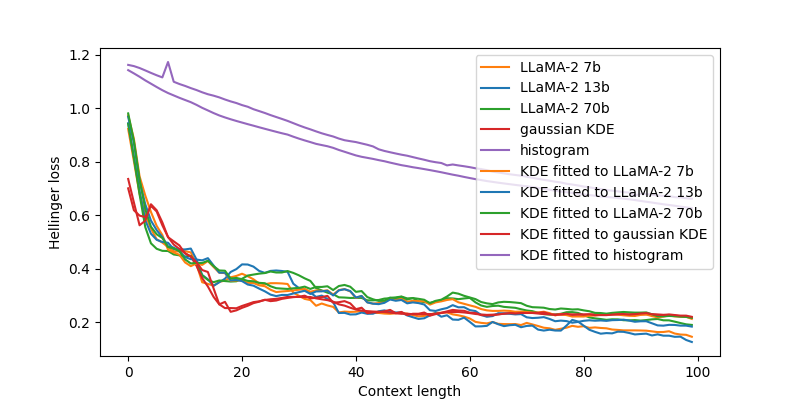

In [233]:
loss_curve_list = []
num_traj_list = [0,1,2,3,4,5,6,7,8,9]
for num_traj in num_traj_list:
    loss_curve = D_Hel[num_traj * traj_len : (num_traj+1) * traj_len, num_trajs * traj_len + geodesic_steps-1]
    loss_curve_list += [loss_curve]

fig = plt.figure(dpi = 100, figsize=(8,4))
ax = fig.add_subplot(111)
for i, loss_curve in enumerate(loss_curve_list):
    ax.plot(loss_curve, label = traj_names[i], c = color_list[i])
plt.legend()    

plt.ylabel("Hellinger loss")
plt.xlabel("Context length")
save_path = f"{name}_Hellinger_1D.png"
plt.savefig(save_path)
# plt.xscale('log')
# plt.yscale('log')

plt.show()



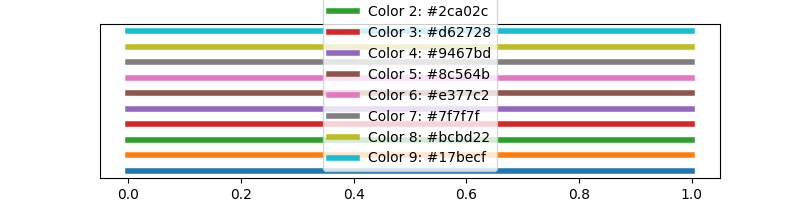

Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


In [234]:
import matplotlib.pyplot as plt

# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot lines with each color in the default color cycle
plt.figure(figsize=(8, 2))
for i, color in enumerate(default_colors):
    plt.plot([0, 1], [i, i], label=f'Color {i}: {color}', color=color, linewidth=4)

plt.legend()
plt.yticks([])
plt.show()

# Print the color codes
for i, color in enumerate(default_colors):
    print(f'Color {i}: {color}')